In [2]:
import warnings
warnings.filterwarnings('ignore')
import flowermd
import hoomd
import gsd
import matplotlib.pyplot as plt
import numpy as np
import gsd.hoomd
from flowermd.base import Pack, Simulation
from flowermd.library import KremerGrestBeadSpring, LJChain
from flowermd.utils import get_target_box_number_density
import unyt as u
import hoomd

cpu = hoomd.device.CPU()

In [3]:
mollengths = [20]

In [4]:
for i in range(len(mollengths)):
    kg_chain = LJChain(lengths=mollengths[i],num_mols=20)
    ff = KremerGrestBeadSpring(bond_k=2.5,bond_max=2.5)
    ff.hoomd_forces
    cg_system = Pack(molecules=kg_chain, density=0.85*u.Unit("nm**-3"), packing_expand_factor=11,edge=2,overlap=1)
    gsd_path=(str(i+1)+'kg-melt.gsd')
g_sim = Simulation(
        initial_state=cg_system.hoomd_snapshot,
        forcefield=ff.hoomd_forces,
        gsd_write_freq=int(1e5/10),
        gsd_file_name=gsd_path,
        device = cpu)
    target_box = get_target_box_number_density(density=0.85*u.Unit("nm**-3"),n_beads=mollengths[i]*10)
    cg_sim.run_update_volume(final_box_lengths=target_box, kT=2.0, n_steps=1e5,tau_kt=cg_sim.dt,period=10,thermalize_particles=True)
    cg_sim.run_NVT(n_steps=1e4, kT=1, tau_kt=0.06)
    cg_sim.flush_writers()
    traj = gsd.hoomd.open(str(i+1)+'kg-melt.gsd')

Initializing simulation state from a gsd.hoomd.Frame.
Step 5500 of 100000; TPS: 13992.31; ETA: 0.1 minutes
Step 11000 of 100000; TPS: 19188.23; ETA: 0.1 minutes
Step 16500 of 100000; TPS: 21689.07; ETA: 0.1 minutes
Step 22000 of 100000; TPS: 23393.65; ETA: 0.1 minutes
Step 27500 of 100000; TPS: 24485.32; ETA: 0.0 minutes
Step 33000 of 100000; TPS: 25653.28; ETA: 0.0 minutes
Step 38500 of 100000; TPS: 26446.43; ETA: 0.0 minutes
Step 44000 of 100000; TPS: 27307.19; ETA: 0.0 minutes
Step 49500 of 100000; TPS: 28119.92; ETA: 0.0 minutes
Step 55000 of 100000; TPS: 28839.3; ETA: 0.0 minutes
Step 60500 of 100000; TPS: 29524.71; ETA: 0.0 minutes
Step 66000 of 100000; TPS: 30036.23; ETA: 0.0 minutes
Step 71500 of 100000; TPS: 30490.03; ETA: 0.0 minutes
Step 77000 of 100000; TPS: 30884.05; ETA: 0.0 minutes
Step 82500 of 100000; TPS: 31007.99; ETA: 0.0 minutes
Step 88000 of 100000; TPS: 31128.68; ETA: 0.0 minutes
Step 93500 of 100000; TPS: 31002.92; ETA: 0.0 minutes
Step 99000 of 100000; TPS: 306

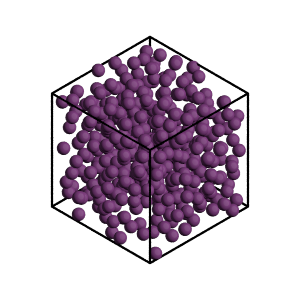

In [5]:
from cmeutils.visualize import FresnelGSD

sim_visualizer = FresnelGSD(
    gsd_file="1kg-melt.gsd", frame=10, view_axis=(1, 1, 1)
)
sim_visualizer.view()

In [6]:
import mbuild as mb
import numpy as np

# define all necessary lattice parameters
spacings = [0.246, 0.246, 0.335]  # nm
angles = [90, 90, 120]
points = [[0, 0, 0], [1/3, 2/3, 0]]  # fractional positions of two carbon atoms

# define lattice object
graphene_lattice = mb.Lattice(
    lattice_spacing=spacings,
    angles=angles,
    lattice_points={'A': points}
)

# define Compound
carbon = mb.Compound(name='C')

# generate graphene sheet
graphene = graphene_lattice.populate(compound_dict={'A': carbon}, x=5, y=5, z=1)

# set bonding cutoff 
cutoff = 0.15 # nm

particles = list(graphene.particles())
n = len(particles)

# create bonds between atoms within cutoff distance
bonds = {}
for i in range(n):
    for j in range(i + 1, n):
        dist = np.linalg.norm(particles[i].pos - particles[j].pos)
        if dist < cutoff:
            graphene.add_bond((particles[i], particles[j]))
            bonds.setdefault(particles[i], []).append(particles[j])
            bonds.setdefault(particles[j], []).append(particles[i])
            
# trimming weird atoms
to_remove = [p for p in particles if len(bonds.get(p)) < 2]
for atom in to_remove:
    graphene.remove(atom)

In [7]:
graphene.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
from flowermd.base import Molecule
from flowermd.base import Pack
from flowermd.library import Graphene

sheet = Graphene(x_repeat=5, y_repeat=5, n_layers=1, periodicity=(False,False,False))
system = Pack(molecules=[Molecule(compound=sheet.all_molecules[0], num_mols=10), kg_chain], density=0.5)

In [9]:
system.visualize()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [10]:
snap = system.hoomd_snapshot
print(snap.particles.types)
print(snap.bonds.types)
print(snap.angles.types)
print(snap.dihedrals.types)

['A', 'C']
['C-C', 'A-A']
['C-C-C', 'A-A-A']
['C-C-C-C', 'A-A-A-A']


In [11]:
from flowermd.library.forcefields import BeadSpring
from flowermd.base.forcefield import BaseHOOMDForcefield

In [12]:
ff = BeadSpring(r_cut=2.5,
        beads={"A": dict(epsilon=1.0, sigma=1.0),
               "C": dict(epsilon=2.0, sigma=2.0)},
        bonds={"C-C": dict(r0=1.1, k=300), "A-A": dict(r0=1.1, k=300)},
        angles={"A-A-A": dict(t0=2.0, k=200),
                "C-C-C": dict(t0=2.0, k=200)},
        dihedrals={"A-A-A-A": dict(phi0=0.0, k=100, d=-1, n=1), "C-C-C-C": dict(phi0=0.0, k=100, d=-1, n=1)})

In [20]:
sim = Simulation(initial_state=system.hoomd_snapshot, forcefield=ff.hoomd_forces, device = cpu)

Initializing simulation state from a gsd.hoomd.Frame.


In [22]:
#target_box = get_target_box_number_density(density=0.85*u.Unit("nm**-3"),n_beads=mollengths[i]*10)
#sim.run_update_volume(final_box_lengths=target_box, kT=2.0, n_steps=1e5,tau_kt=cg_sim.dt,period=10,thermalize_particles=True)
sim.run_NVT(n_steps=1e4, kT=1, tau_kt=0.06)
sim.flush_writers()

SimulationDefinitionError: Cannot add <hoomd.md.pair.pair.LJ object at 0x7fd834427620> to multiple simulations simultaneously.